In [1]:
import pyodbc
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

conn=pyodbc.connect('Driver={SQL Server};'
                    'Server=localhost;'
                    'Database=MentalHealthDB;'
                    'Trusted_Connection=yes;')

query="SELECT * FROM MentalHealthDataset"
df=pd.read_sql(query, conn)
print(df)

     User_ID   Age             Gender  Occupation    Country  \
0        1.0  36.0         Non-binary       Sales     Canada   
1        2.0  34.0             Female   Education         UK   
2        3.0  65.0         Non-binary       Sales        USA   
3        4.0  34.0               Male       Other  Australia   
4        5.0  22.0             Female  Healthcare     Canada   
..       ...   ...                ...         ...        ...   
995    996.0  46.0         Non-binary       Other    Germany   
996    997.0  31.0               Male       Sales     Canada   
997    998.0  33.0             Female          IT    Germany   
998    999.0  42.0             Female     Finance  Australia   
999   1000.0  43.0  Prefer not to say       Sales    Germany   

    Mental_Health_Condition Severity Consultation_History Stress_Level  \
0                        No   Medium                  Yes       Medium   
1                       Yes     None                   No          Low   
2        

C:\Users\jeffg\AppData\Local\Temp\ipykernel_33300\3436331956.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df=pd.read_sql(query, conn)


In [10]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
#X=df[['Age', 'Gender', 'Occupation',
#      'Country', 'Mental_Health_Condition', 'Severity', 'Consultation_History', 'Stress_Level']]
#Y=df['Work_Hours']
numeric=df[['Age', 'Sleep_Hours', 'Work_Hours', 'Physical_Activity_Hours']]
categoric=df[['Gender', 'Occupation', 'Country', 'Mental_Health_Condition', 'Severity', 'Consultation_History', 'Stress_Level']]

#Preprocessing Steps
#Handling categorical values
label_encoders={}
for i in categoric:
    label_encoders[i]=LabelEncoder()
    df[i]=label_encoders[i].fit_transform(df[i].astype(str))
print(df.head())

#Normalize numerical features
numerical_columns=['Age', 'Sleep_Hours', 'Work_Hours', 'Physical_Activity_Hours']
scaler=StandardScaler()
df[numerical_columns]=scaler.fit_transform(df[numerical_columns])
print(df.head())

   User_ID   Age  Gender  Occupation  Country  Mental_Health_Condition  \
0      1.0  36.0       2           6        1                        0   
1      2.0  34.0       0           0        5                        1   
2      3.0  65.0       2           6        6                        1   
3      4.0  34.0       1           5        0                        0   
4      5.0  22.0       0           3        1                        1   

   Severity  Consultation_History  Stress_Level  Sleep_Hours  Work_Hours  \
0         2                     1             2          7.1        46.0   
1         3                     0             1          7.5        47.0   
2         0                     0             1          8.4        58.0   
3         1                     0             2          9.8        30.0   
4         1                     0             2          4.9        62.0   

   Physical_Activity_Hours  
0                      5.0  
1                      8.0  
2          

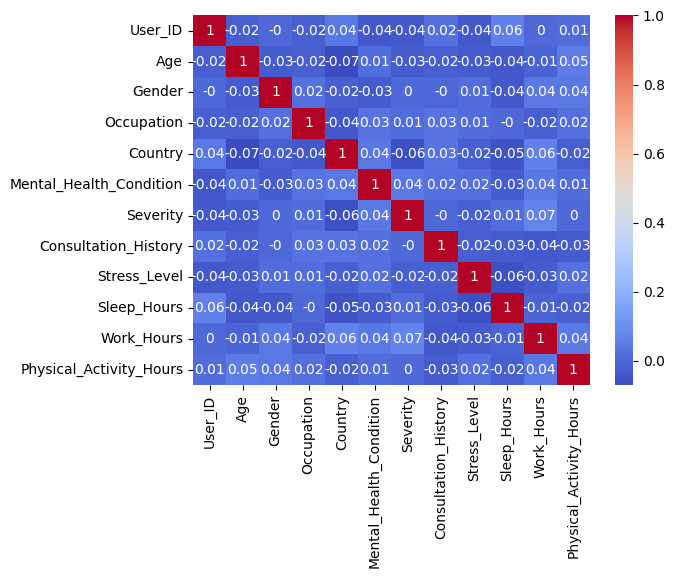

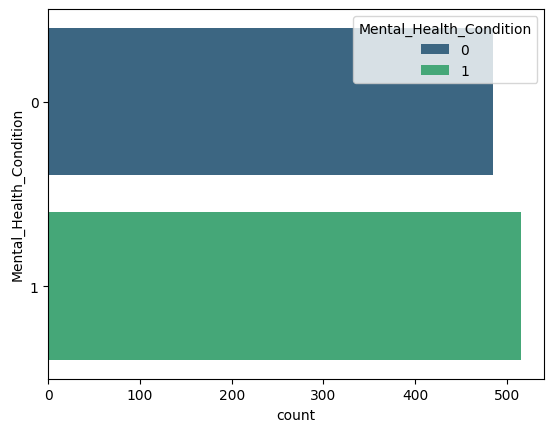

In [11]:
# Normalized correlation matrix
corr_matrix=df.corr(numeric_only=True).round(2)
sns.heatmap(data=corr_matrix, annot=True, cmap="coolwarm")
plt.show()

# Distribution of binary classification variable
sns.countplot(df, y="Mental_Health_Condition", hue="Mental_Health_Condition", palette="viridis")
plt.show()

In [12]:
from sklearn.feature_selection import SelectKBest, f_classif

# Analyzing feature importance
x=df.drop('Mental_Health_Condition', axis=1)
y=df['Mental_Health_Condition']

# Select top 8 features
selector=SelectKBest(f_classif, k=8)
selected=selector.fit_transform(x, y)
features=x.columns[selector.get_support()].tolist()

print("Most relevant features:", features)

Most relevant features: ['User_ID', 'Gender', 'Occupation', 'Country', 'Severity', 'Consultation_History', 'Sleep_Hours', 'Work_Hours']


In [13]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2, random_state=5)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(800, 11)
(200, 11)
(800,)
(200,)


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Logistic Regression
lr_model=LogisticRegression(max_iter=1000, random_state=5)
lr_model.fit(x_train, y_train)
lr_pred=lr_model.predict(x_test)

# Decision Tree
dt_model=DecisionTreeClassifier(random_state=5)
dt_model.fit(x_train, y_train)
dt_pred=dt_model.predict(x_test)

#Perform cross-validation on LR
lr_scores=cross_val_score(lr_model, x_train, y_train, scoring='accuracy', cv=10)
#Perform cross-validation on DT
dt_scores=cross_val_score(dt_model, x_train, y_train, scoring='accuracy', cv=10)

#Cross validation results
print("LR 10-fold cross validation result:")
print("----------------------------")
print("Accuracy is {}".format((lr_scores))+"\n")
print("Average Accuracy is {}".format(np.mean(lr_scores))+"\n")

print("DT 10-fold cross validation result:")
print("----------------------------")
print("Accuracy is {}".format((dt_scores))+"\n")
print("Average Accuracy is {}".format(np.mean(dt_scores))+"\n")

LR 10-fold cross validation result:
----------------------------
Accuracy is [0.5125 0.5    0.55   0.6125 0.325  0.4125 0.6    0.5375 0.525  0.575 ]

Average Accuracy is 0.515

DT 10-fold cross validation result:
----------------------------
Accuracy is [0.5    0.45   0.6    0.5375 0.4875 0.5    0.4875 0.5875 0.4875 0.4125]

Average Accuracy is 0.505



In [15]:
from sklearn.metrics import classification_report

# Evaluate Models
print("Logistic Regression Performance: ")
print(classification_report(y_test, lr_pred))

print("Decision Tree Performance: ")
print(classification_report(y_test, dt_pred))

print("Class Distribution: ")
print(y.value_counts(normalize=True))

Logistic Regression Performance: 
              precision    recall  f1-score   support

           0       0.48      0.45      0.46        98
           1       0.50      0.53      0.51       102

    accuracy                           0.49       200
   macro avg       0.49      0.49      0.49       200
weighted avg       0.49      0.49      0.49       200

Decision Tree Performance: 
              precision    recall  f1-score   support

           0       0.52      0.54      0.53        98
           1       0.55      0.53      0.54       102

    accuracy                           0.54       200
   macro avg       0.54      0.54      0.53       200
weighted avg       0.54      0.54      0.54       200

Class Distribution: 
1    0.515
0    0.485
Name: Mental_Health_Condition, dtype: float64


In [16]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix to check True Positives, False Negatives, etc.
cm=confusion_matrix(y_test, lr_pred)
TN, FP, FN, TP=confusion_matrix(y_test, lr_pred).ravel()
print('True Positive (TP) = ', TP)
print('False Positive (FP) = ', FP)
print('True Negative (TN) = ', TN)
print('False Negative (FN) = ', FN)
print("\n")
cm=confusion_matrix(y_test, dt_pred)
TN, FP, FN, TP=confusion_matrix(y_test, dt_pred).ravel()
print('True Positive (TP) = ', TP)
print('False Positive (FP) = ', FP)
print('True Negative (TN) = ', TN)
print('False Negative (FN) = ', FN)

True Positive (TP) =  54
False Positive (FP) =  54
True Negative (TN) =  44
False Negative (FN) =  48


True Positive (TP) =  54
False Positive (FP) =  45
True Negative (TN) =  53
False Negative (FN) =  48


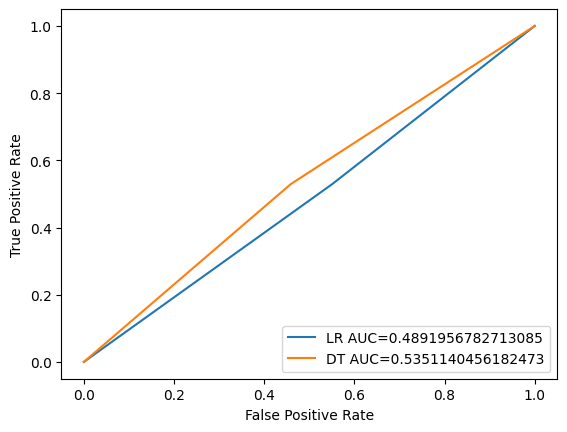

In [17]:
from sklearn.metrics import roc_curve, auc

# Define Logistic Regression metrics
lr_probs=lr_model.predict_proba(x_test)[:,1]
lr_fpr, lr_tpr, _=roc_curve(y_test, lr_pred)
lr_auc=auc(lr_fpr, lr_tpr)

# Define Decision Tree metrics
dt_probs=dt_model.predict_proba(x_test)[:,1]
dt_fpr, dt_tpr, _=roc_curve(y_test, dt_pred)
dt_auc=auc(dt_fpr, dt_tpr)

#Create ROC curve comparison
plt.plot(lr_fpr, lr_tpr, label="LR AUC="+str(lr_auc))
plt.plot(dt_fpr, dt_tpr, label="DT AUC="+str(dt_auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()